In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import cv2
import numpy as np

In [2]:
from utils import *

In [21]:
def match_and_score(real_img, cad_img):
    sift = cv2.SIFT_create(
        nfeatures=500,
        contrastThreshold=0.04, # increase to get fewer keypoints
        edgeThreshold=10
    )

    # Detect keypoints
    kp1, des1 = sift.detectAndCompute(real_img, None)
    kp2, des2 = sift.detectAndCompute(cad_img, None)

    print(f"Readl image keypoints: {len(kp1)}")
    print(f"CAD image keypoints: {len(kp2)}")

    # Use  FLANN matcher instead of brute force   
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    

    # Lowe's Ratio Test
    ratio = 0.7
    good_matches = [m for m,n in matches if m.distance < ratio*n.distance]

    score = len(good_matches) / (len(kp1) + 1e-6)

    return score, kp1, kp2, good_matches

In [22]:
real_img = cv2.imread('images/real/3.jpg')
cad_images = [cv2.imread(f"images/cad/{i}.png") for i in range(1, 6)]

## Visualizations

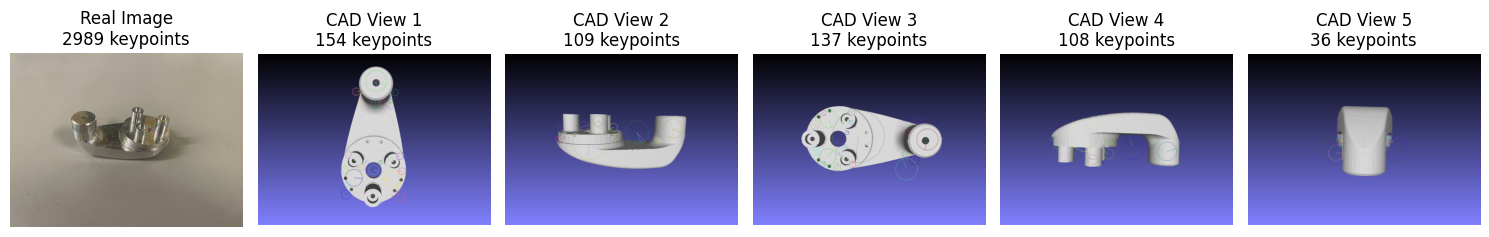

In [ ]:
# visualize_all_keypoints(real_img, cad_images)

# Scoring

In [24]:
scores = []
for cad_img in cad_images:
    score, _, _, _ = match_and_score(real_img, cad_img)
    scores.append(score)

best_idx = np.argmax(scores)

Readl image keypoints: 500
CAD image keypoints: 154
Readl image keypoints: 500
CAD image keypoints: 109
Readl image keypoints: 500
CAD image keypoints: 137
Readl image keypoints: 500
CAD image keypoints: 108
Readl image keypoints: 500
CAD image keypoints: 36


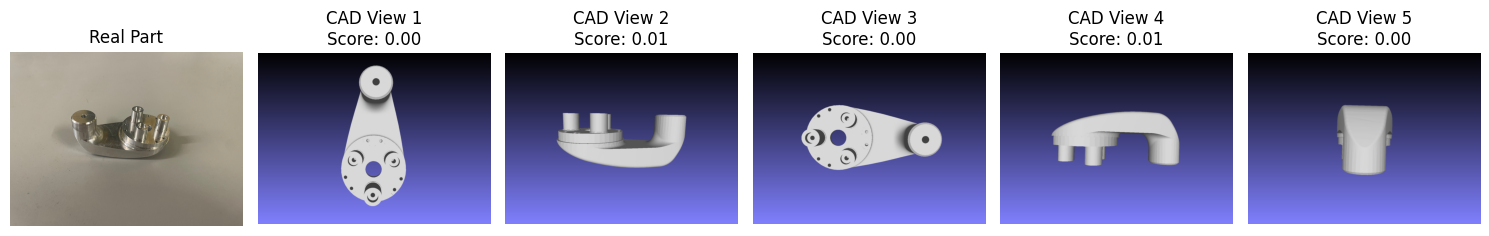

In [25]:
visualize_real_with_cad(real_img, cad_images, scores, best_idx)

# Pose Estimation

In [ ]:
def estimate_pose(kp1, kp2, good_matches, camera_matrix, dist_coeffs):
    # Get coordinates of matched points
    scr_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Filter outliers with RANSAC
    H, inlier_mask = cv2.findHomography(scr_pts, dst_pts, cv2.RANSAC, 5.0)
    inlier_mask = inlier_mask.ravel().tolist() # ravel to 1D array

    # Get inliner points
    inlier_src_pts = scr_pts[inlier_mask]
    inlier_dst_pts = dst_pts[inlier_mask]

    if len(inlier_src_pts) < 4:
        print("Not enough good matches for pose estimation")
        return None

    # PnP
    """
    We need 3D coordinates from CAD model 
    and 2D coordinates from real image
    """
    object_points = np.array([...])

    success, rvec, tvec = cv2.solvePnP(object_points, inlier_dst_pts, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    if success:
        return {"rvec": rvec, "tvec": tvec}, inlier_dst_pts
    else:
        return None
